In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.svm import SVC  # Import SVM classifier
from sklearn.neighbors import KNeighborsClassifier #import KNN classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier #import Random Forest classifier
from sklearn.naive_bayes import GaussianNB #import Naive bayes classifier
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report # for confusion matrix and accuracy measures
import numpy as np # linear algebra
import pandas as pd
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

import pickle # Module to store our models

data = pd.read_csv("/home/shubha/Downloads/Accidents_categorical.csv")
# data = pd.read_csv("Accidents_categorical.csv")
#data.shape

In [2]:
def preprop(data, to_drop=[], na_thresh = 0.25):
    log = []
    for i in to_drop:                           # Explicitly drop specified columns (intuition and logical reasoning) 
        data = data.drop(i, axis=1)
        log.append("Dropped column " + i + " as requested")

    report = getStats(data)
    # print(report)
    replace_index = {}
    for i in report:
        # print(i)
        if i == "uncertain":            # report has a class of uncertain columns; Do nothing to them
            continue
        
        # If numerical column and less than threshold percentage is empty, fill it with mean of column
        if report[i]["type"] == 'num' and report[i]["na"] > 0 and report[i]["na"] < na_thresh :
            data[i] = data[i].fillna(data[i].mean())
            log.append(i + " : replaced Nan/Na with mean")
            
        #If in any column, more than threshold percentage is empty, drop such columns
        elif (report[i]["type"] == 'num' or report[i]["type"] == 'cat') and report[i]["na"] >= na_thresh :
            # print(data.columns)
            data = data.drop(i, axis=1)
            log.append("Dropped column " + i + " as Nan/Na ratio (" + str(report[i]["na"]) + ") > " + str(na_thresh))
            
            
        # If column is categorical, encode them with numerical classes    
        if report[i]["type"] == 'cat' and i in data.columns:
            replace_index[i] = getEncodings(data[i])
            log.append("Encoded column " + i)

    data = data.replace(replace_index)


    return data, log, replace_index # Returning cleaned data, log of changes made and categorical encodings dict (if any)



def getEncodings(o):
    o = list(set(o))
    o = sorted(o)
    enc = {cls: ind for ind, cls in enumerate(o)}
    return enc


def getStats(data):
    cols = data.columns
    report = {}
    report['uncertain'] = []
    for i in cols:
        report[i] = {}
        report[i]["na"] = data[i].isna().sum() / len(data)
        if "unique" in str(data[i].describe()):
            if len(data[i].unique()) <  0.25 * len(data):
                report[i]["type"] = "cat"
                report[i]["uniq"] = data[i].unique()
                report[i]["uniq_no"] = len(data[i].unique())
            else:
                report["uncertain"].append(i)
        else:
            report[i]["type"] = "num"
    return report


# Accident_Index and Datetime provide no useful information
prepro_data, logs, encs = preprop(data, to_drop=["Accident_Index", "Datetime"])  
#print("\n".join(logs))

In [3]:
cols = list(prepro_data.columns)
feature_cols=[]
for i in range(0,len(cols)-1):
    feature_cols.append(cols[i])
#print(feature_cols)
X = prepro_data[feature_cols] # Features
y = prepro_data.Accident_Severity # Target variable

In [4]:
pca = PCA(28)
pca.fit(X)
pca.n_components_
print(pca.explained_variance_ratio_)

[9.98755879e-01 5.77512838e-04 2.18531474e-04 1.49725428e-04
 5.83489607e-05 3.93775284e-05 3.32685173e-05 3.12673134e-05
 2.62673706e-05 2.21586810e-05 1.22229155e-05 1.19452715e-05
 1.12086365e-05 1.05223842e-05 8.62244702e-06 5.63607219e-06
 4.28793289e-06 3.78171770e-06 3.39701988e-06 3.01701333e-06
 2.89662353e-06 2.69541799e-06 2.25923838e-06 1.68898493e-06
 1.37480871e-06 1.20306485e-06 3.96498767e-07 3.28123499e-07]


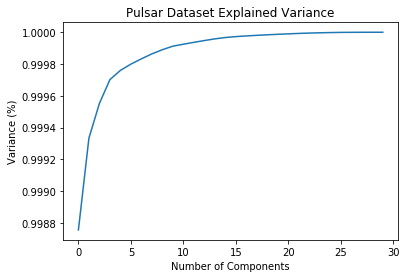

In [5]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [6]:
pca = PCA(n_components=15)
dataset = pca.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [8]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

f = open("dtree_trained.da", "wb")
pickle.dump(clf, f)
f.close()


Accuracy: 64.35605559232297
              precision    recall  f1-score   support

           0       0.32      0.30      0.31     20155
           1       0.75      0.77      0.76     55395

    accuracy                           0.64     75550
   macro avg       0.54      0.53      0.53     75550
weighted avg       0.64      0.64      0.64     75550



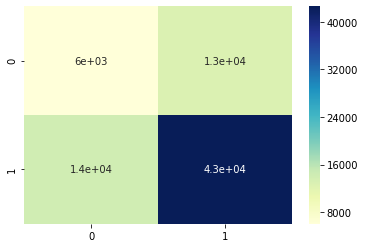

In [9]:
f = open("dtree_trained.da", "rb")
clf = pickle.load(f)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100)
cm = confusion_matrix(y_test, y_pred) 
sns.heatmap(cm,annot=True,cmap="YlGnBu")
print(classification_report(y_pred, y_test))

No Skill: ROC AUC=0.500
Decision Trees: ROC AUC=0.536


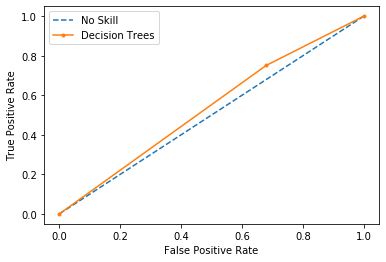

In [10]:
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
f = open("dtree_trained.da", "rb")
model = pickle.load(f)

lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Trees: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Decision Trees')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# training a linear SVM classifier
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 

f = open("svm_trained.da", "wb")
pickle.dump(svm_model_linear, f)


In [ ]:
f = open("svm_trained.da", "rb")
svm_model_linear = pickle.load(f)

svm_predictions = svm_model_linear.predict(X_test) 
print("Accuracy:",metrics.accuracy_score(y_test, svm_predictions)*100)

cm = confusion_matrix(y_test, svm_predictions) 
sns.heatmap(cm,annot=True,cmap="YlGnBu")
print(classification_report(y_pred, y_test))

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
# fit a model

f = open("svm_trained.da", "rb")
model = pickle.load(f)

lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('KNN: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [11]:
# training a KNN classifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train) 

f = open("knn_trained.da", "wb")
pickle.dump(knn, f)



Accuracy: 72.7200529450695
              precision    recall  f1-score   support

           0       0.32      0.30      0.31     20108
           1       0.75      0.77      0.76     55442

    accuracy                           0.64     75550
   macro avg       0.53      0.53      0.53     75550
weighted avg       0.64      0.64      0.64     75550



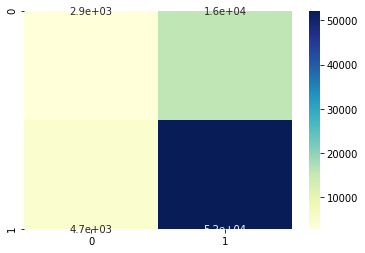

In [12]:
f = open("knn_trained.da", "rb")
knn = pickle.load(f)

# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
print("Accuracy:",accuracy*100) 
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm = confusion_matrix(y_test, knn_predictions) 
sns.heatmap(cm,annot=True,cmap="YlGnBu")
print(classification_report(y_pred, y_test))

No Skill: ROC AUC=0.500
KNN: ROC AUC=0.570


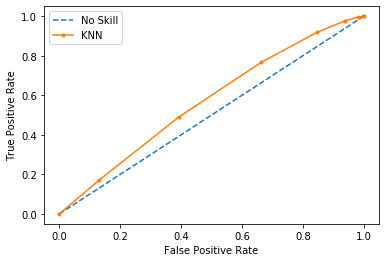

In [13]:
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
f = open("knn_trained.da", "rb")
model = pickle.load(f)
# model = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train) 

lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('KNN: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [14]:
#training Random Forest model
clf=RandomForestClassifier(n_estimators=500)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

f = open("randomForest_trained.da", "wb")
pickle.dump(clf, f)


KeyboardInterrupt: 

In [ ]:
f = open("randomForest_trained.da", "rb")
clf = pickle.load(f)

y_pred=clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100)
cm = confusion_matrix(y_test, y_pred) 
sns.heatmap(cm,annot=True,cmap="YlGnBu")
print(classification_report(y_pred, y_test))

No Skill: ROC AUC=0.500
RF: ROC AUC=0.651


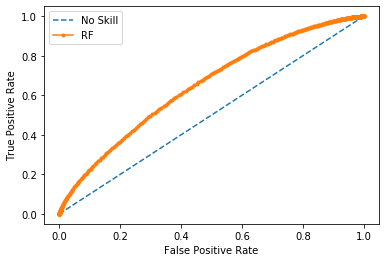

In [23]:
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
f = open("randomForest_trained.da", "rb")
model = pickle.load(f)
# model = RandomForestClassifier(n_estimators=500)

#Train the model using the training sets y_pred=clf.predict(X_test)
# model=model.fit(X_train,y_train)

lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RF: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='RF')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [15]:
#training Naive Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

f = open("naiveBayes_trained.da", "wb")
pickle.dump(model, f)


Accuracy: 75.0152217074785
              precision    recall  f1-score   support

           0       0.05      0.49      0.10      2076
           1       0.98      0.76      0.85     73474

    accuracy                           0.75     75550
   macro avg       0.52      0.63      0.48     75550
weighted avg       0.96      0.75      0.83     75550



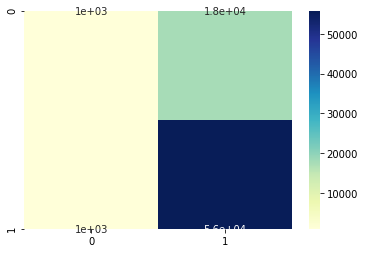

In [16]:
f = open("naiveBayes_trained.da", "rb")
model = pickle.load(f)

y_pred=model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100)
cm = confusion_matrix(y_test, y_pred) 
sns.heatmap(cm,annot=True,cmap="YlGnBu")
print(classification_report(y_pred, y_test))

No Skill: ROC AUC=0.500
NB: ROC AUC=0.610


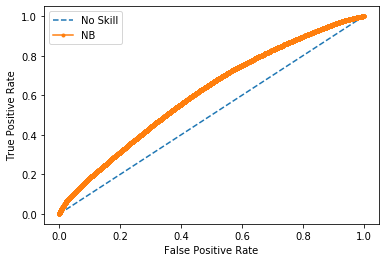

In [17]:
ns_probs = [0 for _ in range(len(y_test))]
# fit a model

f = open("naiveBayes_trained.da", "rb")
model = pickle.load(f)

#Train the model using the training sets y_pred=clf.predict(X_test)
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('NB: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='NB')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [26]:
abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

f = open("adaBoost_trained.da", "wb")
pickle.dump(model, f)


Accuracy: 75.52349437458636
              precision    recall  f1-score   support

           0       0.06      0.60      0.11      1904
           1       0.99      0.76      0.86     73646

    accuracy                           0.76     75550
   macro avg       0.52      0.68      0.48     75550
weighted avg       0.96      0.76      0.84     75550



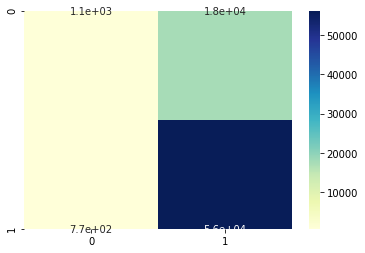

In [44]:
f = open("adaBoost_trained.da", "rb")
model = pickle.load(f)

y_pred=model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100)
cm = confusion_matrix(y_test, y_pred) 
sns.heatmap(cm,annot=True,cmap="YlGnBu")
print(classification_report(y_pred, y_test))

No Skill: ROC AUC=0.500
AB: ROC AUC=0.633


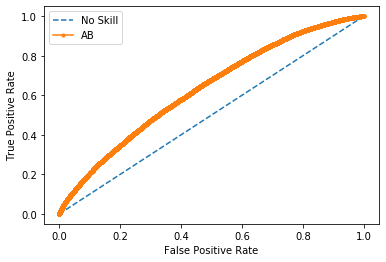

In [45]:
ns_probs = [0 for _ in range(len(y_test))]

f = open("adaBoost_trained.da", "rb")
model = pickle.load(f)

#Train the model using the training sets y_pred=clf.predict(X_test)
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('AB: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='AB')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [31]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)#.fit(X_train, y_train)
model = gbc.fit(X_train, y_train)

f = open("gradientBoost_trained.da", "wb")
pickle.dump(model, f)



Accuracy: 0.7553408338848445
              precision    recall  f1-score   support

           0       0.06      0.60      0.11      1934
           1       0.99      0.76      0.86     73616

    accuracy                           0.76     75550
   macro avg       0.52      0.68      0.48     75550
weighted avg       0.96      0.76      0.84     75550



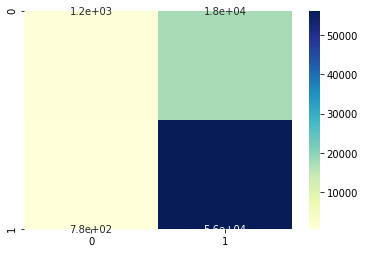

In [32]:
f = open("gradientBoost_trained.da", "rb")
model = pickle.load(f)

#Predict the response for test dataset
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred) 
sns.heatmap(cm,annot=True,cmap="YlGnBu")
print(classification_report(y_pred, y_test))

No Skill: ROC AUC=0.500
GB: ROC AUC=0.636


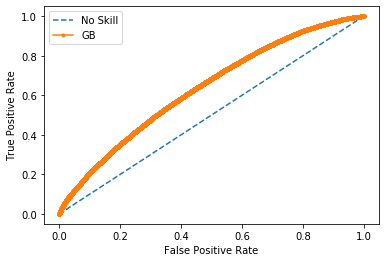

In [33]:
ns_probs = [0 for _ in range(len(y_test))]
# fit a model

f = open("gradientBoost_trained.da", "rb")
model = pickle.load(f)

# model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
#Train the model using the training sets y_pred=clf.predict(X_test)
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('GB: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='GB')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [35]:
classifier = LogisticRegression(random_state = 0) 
classifier.fit(X_train, y_train)

f = open("logRegression_trained.da", "wb")
pickle.dump(classifier, f)


c:\users\avinash m s\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy :  0.7505095962938452
              precision    recall  f1-score   support

           0       0.00      0.59      0.00        29
           1       1.00      0.75      0.86     75521

    accuracy                           0.75     75550
   macro avg       0.50      0.67      0.43     75550
weighted avg       1.00      0.75      0.86     75550



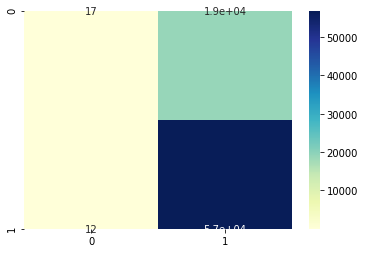

In [36]:
f = open("logRegression_trained.da", "rb")
model = pickle.load(f)

y_pred = model.predict(X_test)
print ("Accuracy : ", accuracy_score(y_test, y_pred)) 
cm = confusion_matrix(y_test, y_pred) 
sns.heatmap(cm,annot=True,cmap="YlGnBu")
print(classification_report(y_pred, y_test))

No Skill: ROC AUC=0.500
LR: ROC AUC=0.606


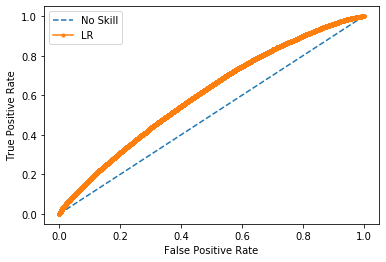

In [37]:
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
f = open("logRegression_trained.da", "rb")
model = pickle.load(f)

#Train the model using the training sets y_pred=clf.predict(X_test)
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LR: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LR')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [38]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(10,7), random_state=1)
clf.fit(X_train, y_train)   

f = open("ann_trained.da", "wb")
pickle.dump(clf, f)


Accuracy :  0.736651224354732
              precision    recall  f1-score   support

           0       0.02      0.20      0.03      1716
           1       0.98      0.75      0.85     73834

    accuracy                           0.74     75550
   macro avg       0.50      0.47      0.44     75550
weighted avg       0.95      0.74      0.83     75550



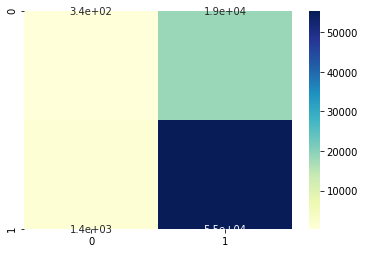

In [40]:
f = open("ann_trained.da", "rb")
clf = pickle.load(f)

y_pred=clf.predict(X_test)
print ("Accuracy : ", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred) 
sns.heatmap(cm,annot=True,cmap="YlGnBu")
print(classification_report(y_pred, y_test))

No Skill: ROC AUC=0.500
LR: ROC AUC=0.458


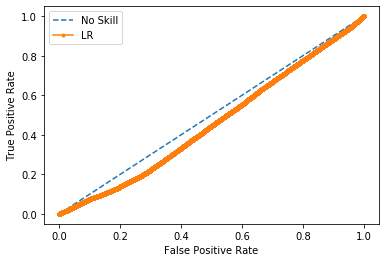

In [41]:
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
f = open("ann_trained.da", "rb")
model = pickle.load(f)


#Train the model using the training sets y_pred=clf.predict(X_test)
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LR: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LR')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [8]:
# Point Biserial Coefficient

from scipy import stats
a1=prepro_data["Season"]
a2=prepro_data["Month_of_Year"]
a3=prepro_data["Age_of_Vehicle"]
a4=prepro_data["Age_of_Driver"]
a5=prepro_data["Engine_CC"]
a6=prepro_data["Day_of_Week"]
b=prepro_data["Accident_Severity"]

print("Point Biserial coefficient between Season and Accident Severity: ",stats.pointbiserialr(a1, b))
print("Point Biserial coefficient between Month of year and Accident Severity: ",stats.pointbiserialr(a2, b))
print("Point Biserial coefficient between Age of vehicle and Accident Severity: ",stats.pointbiserialr(a3, b))
print("Point Biserial coefficient between Age of driver and Accident Severity: ",stats.pointbiserialr(a4, b))
print("Point Biserial coefficient between Age of engine CC and Accident Severity: ",stats.pointbiserialr(a5, b))
print("Point Biserial coefficient between Age of Day of week and Accident Severity: ",stats.pointbiserialr(a6, b))

Point Biserial coefficient between Season and Accident Severity:  PointbiserialrResult(correlation=0.016016602166187454, pvalue=9.126777932869898e-16)
Point Biserial coefficient between Month of year and Accident Severity:  PointbiserialrResult(correlation=-0.0012334428586992386, pvalue=0.5359333981655178)
Point Biserial coefficient between Age of vehicle and Accident Severity:  PointbiserialrResult(correlation=-0.018946769798959734, pvalue=1.928035558926389e-21)
Point Biserial coefficient between Age of driver and Accident Severity:  PointbiserialrResult(correlation=-0.030672448071884156, pvalue=1.7449156578904768e-53)
Point Biserial coefficient between Age of engine CC and Accident Severity:  PointbiserialrResult(correlation=0.06760223766883905, pvalue=7.728317102029654e-253)
Point Biserial coefficient between Age of Day of week and Accident Severity:  PointbiserialrResult(correlation=-0.032411472850780096, pvalue=1.632792791103393e-59)


In [9]:
#Phi coefficients

from sklearn.metrics import matthews_corrcoef

a1=prepro_data["High_Wind"]
a2=prepro_data["Urban_or_Rural_Area"]
a3=prepro_data["Road_Type"]
b=prepro_data["Accident_Severity"]

print("Phi coefficient between High winds and Accident Severity: ",matthews_corrcoef(a1, b))
print("Phi coefficient between Urban or rural area and Accident Severity: ",matthews_corrcoef(a2, b))
print("Phi coefficient between Road type and Accident Severity: ",matthews_corrcoef(a3, b))

Phi coefficient between High winds and Accident Severity:  -0.00044362419961677937
Phi coefficient between Urban or rural area and Accident Severity:  0.09238117964230215
Phi coefficient between Road type and Accident Severity:  -0.008714093370740559
